In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sb

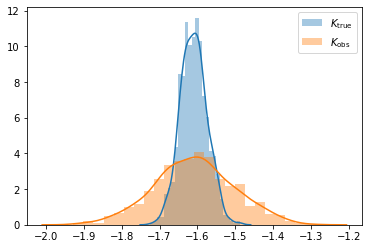

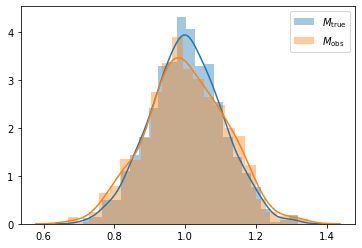

In [36]:
def trueK(alpha,beta,M):
    return alpha+(M-1)*beta

N=1000
Mm=1
Ms=0.1
M_obs_sigma=0.05
M_true=np.random.randn(N)*Ms+Mm
M_obs=np.random.randn(N)*M_obs_sigma+M_true

K_sigma=0.03
Alpha=-1.61
Beta=1/5
K_true=trueK(Alpha, Beta, M_true)+np.random.randn(N)*K_sigma
K_obs_sigma=0.1
K_obs=np.random.randn(N)*K_obs_sigma+K_true

ax = sb.distplot(K_true, label=r'$K_{\rm true}$')
ax = sb.distplot(K_obs, label=r'$K_{\rm obs}$')
ax.legend()
plt.show()
ax = sb.distplot(M_true, label=r'$M_{\rm true}$')
ax = sb.distplot(M_obs, label=r'$M_{\rm obs}$')
ax.legend()

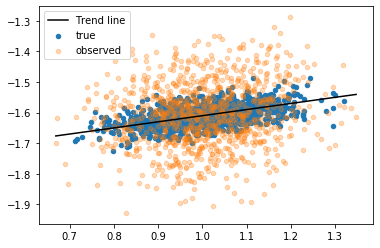

In [37]:
plt.scatter(M_true,K_true,s=20,label='true')
plt.scatter(M_obs,K_obs,s=20,alpha=0.3,label='observed')
M_x=np.linspace(min([*M_obs,*M_true]),max([*M_true,*M_obs]),100)
K_y=trueK(Alpha, Beta, M_x)
plt.plot(M_x,K_y,color='k',label='Trend line')
plt.legend()
plt.show()

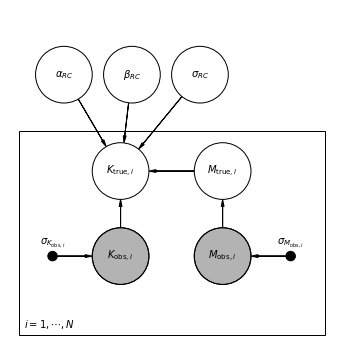

In [38]:
#copy and pasted this cause I already understand how daft works
import daft
pgm = daft.PGM([3,3], grid_unit=4, node_unit=2)
# Hierarchical parameters.
pgm.add_node(daft.Node("alpha", r"$\alpha_{RC}$", 0.5, 2.6))
pgm.add_node(daft.Node("beta", r"$\beta_{RC}$", 1.1, 2.6))
pgm.add_node(daft.Node("sigma", r"$\sigma_{RC}$", 1.7, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("K_true", r"$K_{{\rm true},i}$", 1, 1.75))
pgm.add_node(daft.Node("M_true", r"$M_{{\rm true},i}$", 1.9, 1.75))
# Data.
pgm.add_node(daft.Node("K_obs", r"$K_{{\rm obs},i}$", 1, 1, observed=True))
pgm.add_node(daft.Node("Kerr", r"$\sigma_{K_{{\rm obs},i}}$", 0.4, 1.0, fixed=True, offset=[0.0,0.4]))
pgm.add_node(daft.Node("M_obs", r"$M_{{\rm obs},i}$", 1.9, 1, observed=True))
pgm.add_node(daft.Node("Merr", r"$\sigma_{M_{{\rm obs},i}}$", 2.5, 1.0, fixed=True, offset=[0.0,0.4]))
# Add in the edges.
pgm.add_edge("alpha", "K_true")
pgm.add_edge("beta", "K_true")
pgm.add_edge("sigma", "K_true")
pgm.add_edge("M_true", 'K_true')
pgm.add_edge("M_obs", "M_true")
pgm.add_edge("Merr", "M_obs")
pgm.add_edge("K_obs", "K_true")
pgm.add_edge("Kerr", "K_obs")
# And a plate.
pgm.add_plate(daft.Plate([0.1, 0.4, 2.7, 1.7], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

In [52]:
model=pm.Model()
with model:
    alpha=pm.Normal('alpha',-1.61,0.5)
    beta=pm.Normal('beta',0,10)
    sigma=pm.Lognormal('sigma',np.log(0.03),0.5)
    
    Mtrue=pm.Normal('Mtrue',1.2,0.3,shape=N)
    Mobs=pm.Normal('Mobs',Mtrue,M_obs_sigma,observed=M_obs)
    
    Ktrue=pm.Normal('Ktrue',trueK(alpha,beta,Mtrue),sigma,shape=N)
    Kobs=pm.Normal('Kobs',Ktrue,K_obs_sigma,observed=K_obs)

with model:
    trace=pm.sample(tune=50000, chains=4, target_accept=0.9)

pm.summary(trace,var_names=['alpha','beta','sigma'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Ktrue, Mtrue, sigma, beta, alpha]
Sampling 4 chains: 100%|████████████████████████████████████████████████████| 202000/202000 [22:19<00:00, 94.23draws/s]
The acceptance probability does not match the target. It is 0.7302400707504729, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8245088809175461, but should be close to 0.9. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-1.609882,0.003247,0.000187,-1.616170,-1.603397,284.101273,1.006045
beta,0.145426,0.030116,0.001917,0.084606,0.201257,159.389878,1.001114
sigma,0.026655,0.006145,0.000585,0.013731,0.036935,6.830047,1.330865


In [53]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-1.609882,0.003247,0.000187,-1.616170,-1.603397,284.101273,1.006045
beta,0.145426,0.030116,0.001917,0.084606,0.201257,159.389878,1.001114
Mtrue__0,0.880863,0.046720,0.000797,0.785088,0.968211,3508.923508,0.999378
Mtrue__1,1.010861,0.049470,0.000785,0.910941,1.102378,3531.591465,0.999202
Mtrue__2,1.025263,0.046807,0.000784,0.938189,1.122926,2935.474546,0.999410
Mtrue__3,0.974570,0.048172,0.000873,0.874304,1.059666,3104.440730,1.000370
Mtrue__4,1.008648,0.048275,0.000747,0.909479,1.094401,3697.580757,0.999661
Mtrue__5,0.919372,0.045887,0.000761,0.828481,1.009427,4101.818079,0.999226
Mtrue__6,0.922428,0.049487,0.000861,0.818464,1.011397,3394.803506,0.999031
Mtrue__7,0.847838,0.049784,0.000729,0.756005,0.948858,4276.699187,0.999393


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022CC835E9B0>,
      dtype=object)

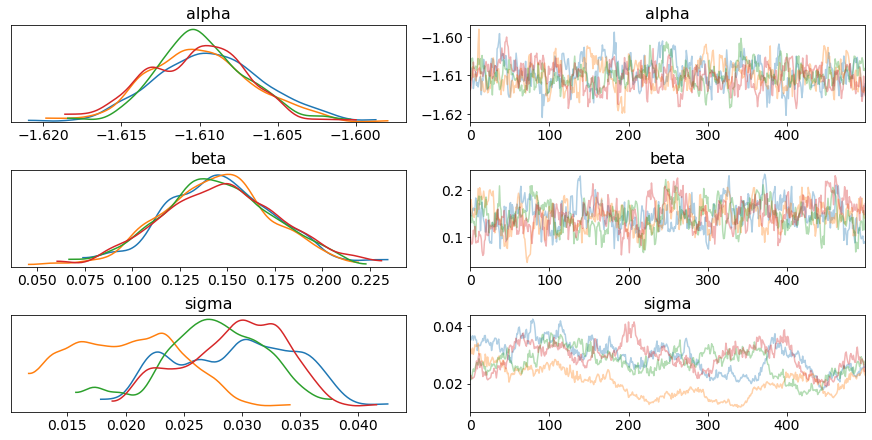

In [54]:
pm.plots.traceplot(trace,var_names=['alpha','beta','sigma'])

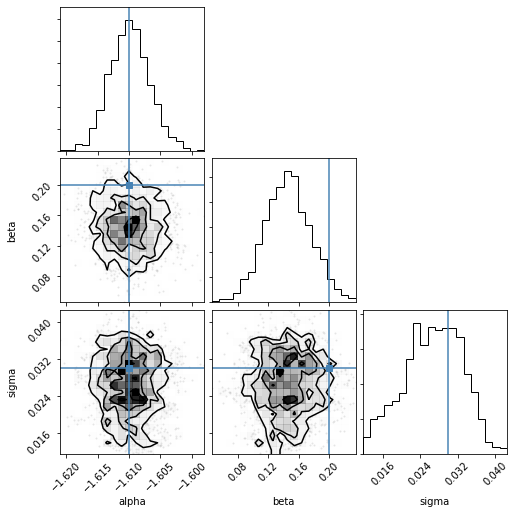

In [55]:
import corner
data=np.vstack((trace['alpha'],trace['beta'],trace['sigma'])).T
corner.corner(data,labels=['alpha','beta','sigma'],truths=[Alpha,Beta,K_sigma])
plt.show()